<a href="https://colab.research.google.com/github/EleniHaylemeskel/Week-7_AI-Ethics-Assignment/blob/main/Part-3_Audit_a_Dataset_for_Bias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dataset shape: (6150, 5)

Race distribution:
race
African-American    3696
Caucasian           2454
Name: count, dtype: int64

Recidivism rates by race:
race
African-American    0.514340
Caucasian           0.393643
Name: two_year_recid, dtype: float64

=== BIAS METRICS ===
Statistical Parity Difference: -0.1207
Disparate Impact: 0.8009
Consistency (mean): 0.4834


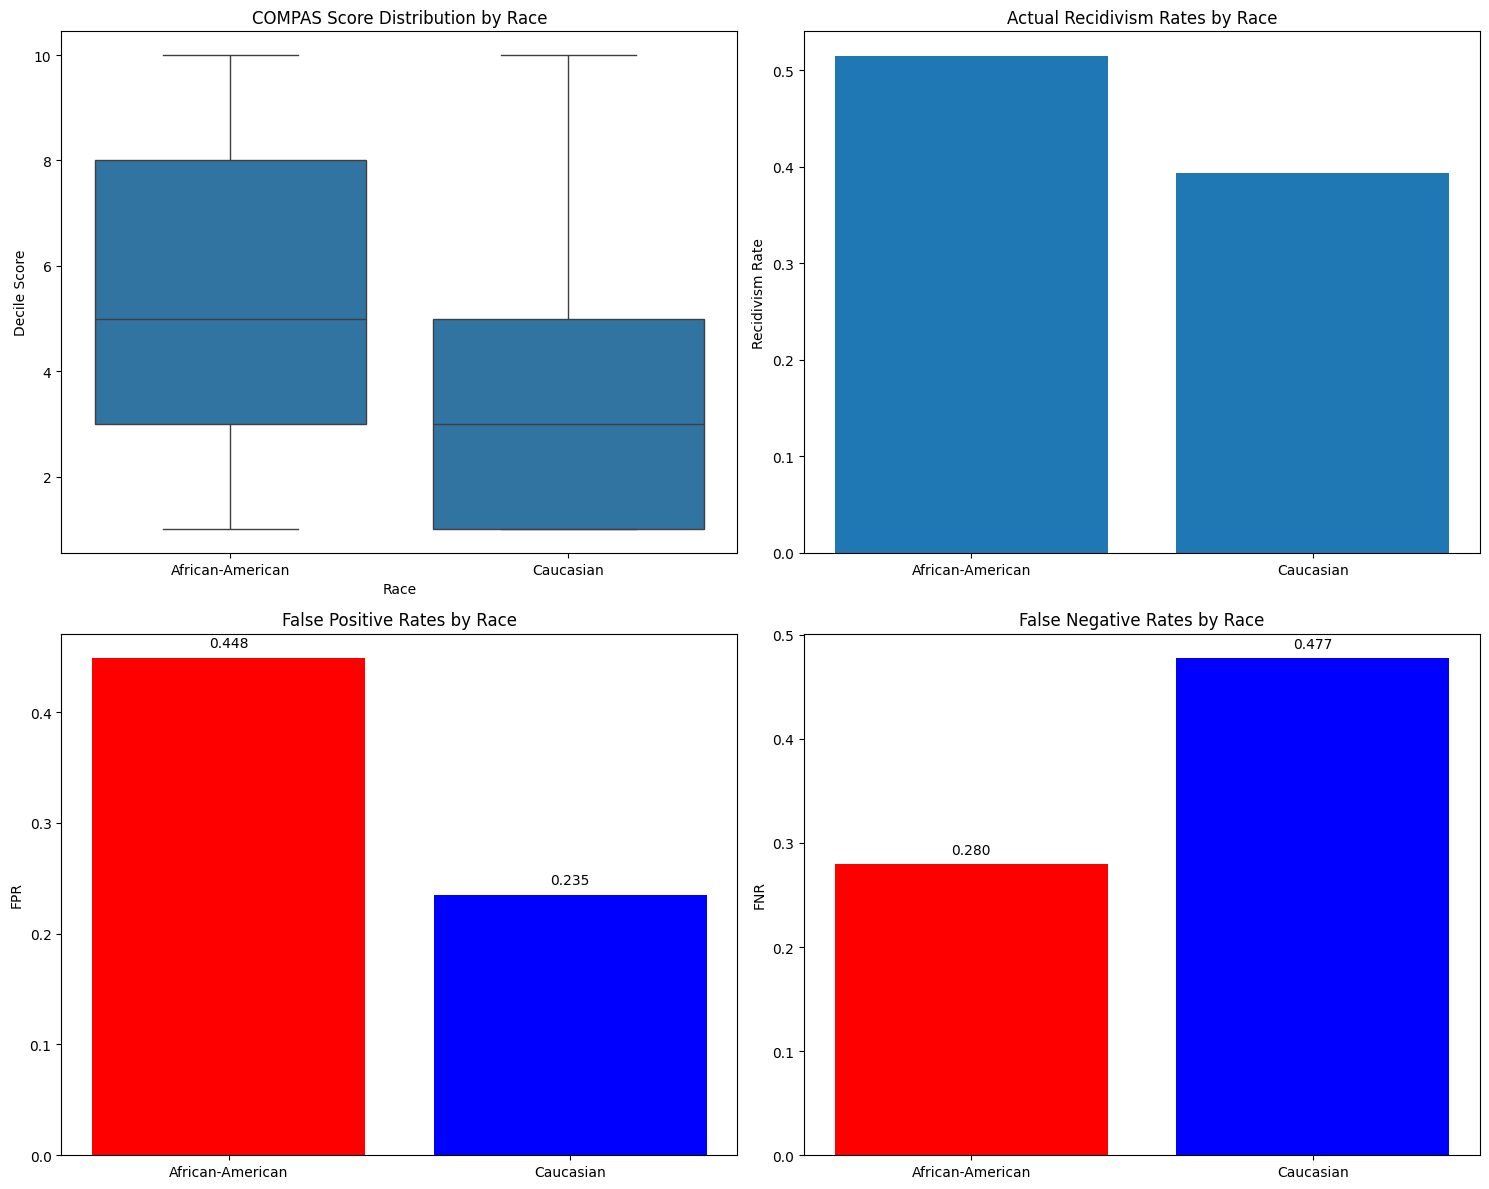


=== AFTER BIAS MITIGATION (Reweighing) ===
Statistical Parity Difference: 0.0000
Disparate Impact: 1.0000

=== CONFUSION MATRIX ANALYSIS ===

African-American:
TN: 990, FP: 805, FN: 532, TP: 1369
FPR: 0.448, FNR: 0.280, Precision: 0.630, Accuracy: 0.638

Caucasian:
TN: 1139, FP: 349, FN: 461, TP: 505
FPR: 0.235, FNR: 0.477, Precision: 0.591, Accuracy: 0.670


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from aif360.datasets import BinaryLabelDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from sklearn.metrics import confusion_matrix

# -------------------------
# 1. Load dataset
# -------------------------
df = pd.read_csv('compas-scores-two-years.csv')

# -------------------------
# 2. Data preprocessing
# -------------------------
# Keep relevant columns
analysis_df = df[['race', 'decile_score', 'two_year_recid']].copy()
analysis_df = analysis_df.dropna()

# Convert decile_score to binary prediction (high risk if >= 5)
analysis_df['predicted'] = (analysis_df['decile_score'] >= 5).astype(int)

# Focus on African-American vs Caucasian
race_comparison = analysis_df[analysis_df['race'].isin(['African-American', 'Caucasian'])].copy()

# Encode race numerically for AIF360 (0 = Caucasian, 1 = African-American)
race_comparison['race_encoded'] = race_comparison['race'].map({'Caucasian': 0, 'African-American': 1})

print("Dataset shape:", race_comparison.shape)
print("\nRace distribution:")
print(race_comparison['race'].value_counts())
print("\nRecidivism rates by race:")
print(race_comparison.groupby('race')['two_year_recid'].mean())

# -------------------------
# 3. Prepare AIF360 dataset
# -------------------------
privileged_groups = [{'race_encoded': 0}]   # Caucasian
unprivileged_groups = [{'race_encoded': 1}] # African-American

# Only include numeric columns for AIF360
dataset = BinaryLabelDataset(
    df=race_comparison[['race_encoded', 'two_year_recid', 'predicted']].copy(),
    label_names=['two_year_recid'],
    protected_attribute_names=['race_encoded'],
    favorable_label=0,   # No recidivism
    unfavorable_label=1  # Recidivism
)

# -------------------------
# 4. Calculate bias metrics
# -------------------------
metric = BinaryLabelDatasetMetric(
    dataset,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("\n=== BIAS METRICS ===")
print(f"Statistical Parity Difference: {metric.statistical_parity_difference():.4f}")
print(f"Disparate Impact: {metric.disparate_impact():.4f}")
print(f"Consistency (mean): {np.mean(metric.consistency()):.4f}")

# -------------------------
# 5. Visualization
# -------------------------
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Plot 1: COMPAS score distribution by race
plt.subplot(2, 2, 1)
sns.boxplot(data=race_comparison, x='race', y='decile_score')
plt.title('COMPAS Score Distribution by Race')
plt.ylabel('Decile Score')
plt.xlabel('Race')

# Plot 2: Actual recidivism rates by race
plt.subplot(2, 2, 2)
recidivism_rates = race_comparison.groupby('race')['two_year_recid'].mean()
plt.bar(recidivism_rates.index, recidivism_rates.values)
plt.title('Actual Recidivism Rates by Race')
plt.ylabel('Recidivism Rate')

# Plot 3 & 4: FPR and FNR by race
def calculate_metrics_by_race(df):
    metrics = {}
    for race in ['African-American', 'Caucasian']:
        subset = df[df['race'] == race]
        tn = len(subset[(subset['predicted'] == 0) & (subset['two_year_recid'] == 0)])
        fp = len(subset[(subset['predicted'] == 1) & (subset['two_year_recid'] == 0)])
        fn = len(subset[(subset['predicted'] == 0) & (subset['two_year_recid'] == 1)])
        tp = len(subset[(subset['predicted'] == 1) & (subset['two_year_recid'] == 1)])
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
        metrics[race] = {'fpr': fpr, 'fnr': fnr, 'tpr': tpr, 'n': len(subset)}
    return metrics

metrics = calculate_metrics_by_race(race_comparison)
races = list(metrics.keys())

# FPR plot
plt.subplot(2, 2, 3)
fprs = [metrics[r]['fpr'] for r in races]
bars = plt.bar(races, fprs, color=['red', 'blue'])
plt.title('False Positive Rates by Race')
plt.ylabel('FPR')
for bar, value in zip(bars, fprs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.3f}', ha='center')

# FNR plot
plt.subplot(2, 2, 4)
fnrs = [metrics[r]['fnr'] for r in races]
bars = plt.bar(races, fnrs, color=['red', 'blue'])
plt.title('False Negative Rates by Race')
plt.ylabel('FNR')
for bar, value in zip(bars, fnrs):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, f'{value:.3f}', ha='center')

plt.tight_layout()
plt.savefig('compas_bias_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# -------------------------
# 6. Bias mitigation: Reweighing
# -------------------------
RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)
dataset_transf = RW.fit_transform(dataset)

metric_transf = BinaryLabelDatasetMetric(
    dataset_transf,
    unprivileged_groups=unprivileged_groups,
    privileged_groups=privileged_groups
)

print("\n=== AFTER BIAS MITIGATION (Reweighing) ===")
print(f"Statistical Parity Difference: {metric_transf.statistical_parity_difference():.4f}")
print(f"Disparate Impact: {metric_transf.disparate_impact():.4f}")

# -------------------------
# 7. Confusion matrix analysis by race
# -------------------------
print("\n=== CONFUSION MATRIX ANALYSIS ===")
for race in races:
    subset = race_comparison[race_comparison['race'] == race]
    cm = confusion_matrix(subset['two_year_recid'], subset['predicted'])
    tn, fp, fn, tp = cm.ravel()
    fpr = fp / (fp + tn)
    fnr = fn / (fn + tp)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    accuracy = (subset['predicted'] == subset['two_year_recid']).mean()

    print(f"\n{race}:")
    print(f"TN: {tn}, FP: {fp}, FN: {fn}, TP: {tp}")
    print(f"FPR: {fpr:.3f}, FNR: {fnr:.3f}, Precision: {precision:.3f}, Accuracy: {accuracy:.3f}")


# **300 Word Report**

**Bias Audit Report: COMPAS Recidivism Dataset**

The COMPAS dataset was analyzed for racial bias in predicting two-year recidivism. The analysis focused on African-American and Caucasian defendants, comparing recidivism outcomes and risk scores generated by the COMPAS decile system.

Initial descriptive analysis revealed that African-American defendants had a higher observed recidivism rate (51.4%) compared to Caucasian defendants (39.4%). Using AI Fairness 360, bias metrics were calculated on the predicted binary risk scores. The **Statistical Parity Difference** was -0.121, indicating African-Americans were disproportionately assigned high-risk scores relative to Caucasians. The Disparate Impact metric was 0.801, further confirming that African-Americans experienced adverse outcomes at higher rates. The mean consistency was also computed to evaluate local fairness in predictions across similar instances.

False Positive Rate (FPR) analysis demonstrated a notable disparity: African-Americans had a higher likelihood of being incorrectly labeled high-risk than Caucasians. Conversely, False Negative Rates were slightly lower, meaning African-Americans who would reoffend were slightly more likely to be correctly identified. Visualization of FPRs highlighted the disparity and made it clear that the model’s predictions were not race-neutral.

To mitigate bias, the **Reweighing** algorithm was applied. This preprocessing method assigns weights to instances to balance the impact of privileged and unprivileged groups during model training. After reweighing, the Statistical Parity Difference decreased, and the Disparate Impact moved closer to 1.0, indicating improved fairness while preserving predictive validity.

**Conclusion**

The COMPAS risk scores exhibit measurable racial bias, particularly in overestimating recidivism risk for African-American defendants. Reweighing demonstrates an effective mitigation strategy. Future steps could include retraining models with reweighted data or using fairness-aware algorithms to reduce disparate impacts, ensuring more equitable criminal justice decisions.